* Define the model 

In [1]:
# DEFINE the MODEL 
library(rjags)
#nP.I   number of people in test gp who Infected
#nV.I   number of people in vaccine gp who Infected
#nV     number people in vaccine gp
#nP     number people in test gp
#pA     probability to get infected
#prob   probability to get infected while you are vaccinated
#epsilon efficacy of vaccine

model_vaccine <- "model{
nP.I ~ dbin(pA, nP)         # dbinom() in R 
nV.A ~ dbin(pA, nV) 
nV.I ~ dbin(prob, nV.A)     # prob = 1 - epsilon

# Priors of nodes with no parents 
pA ~ dbeta(1,1) 
prob ~ dbeta(1,1) 

epsilon <- 1 - prob         # the quantity we want to trace in the chain 
}"

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



In [5]:
model_load <- function(data) {
  m_j <- jags.model(textConnection(model_vaccine),data=data,inits = list(.RNG.name= "base::Wichmann-Hill", .RNG.seed=14))
  return(m_j)                                             
}

# DATA
nuvaxovid <- list(nV.I=14,nP.I=63,nV=17312,nP=8140)

model_jags_nuvaxovid <- model_load(nuvaxovid)
update(model_jags_nuvaxovid, 1000) 

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 9

Initializing model



In [8]:
post_sim <- coda.samples(model=model_jags_nuvaxovid,variable.names = c("epsilon","nV.A"),n.iter=100000)
posterior_nuvaxovid<- post_sim
Summary_nuvaxovid <- summary(posterior_nuvaxovid)
Summary_nuvaxovid$statistics

,Mean,SD,Naive SE,Time-series SE
epsilon,0.8860315,0.03307419,0.0001045898,0.0001974246
nV.A,132.7780500,20.42609704,0.0645929904,0.1744839255


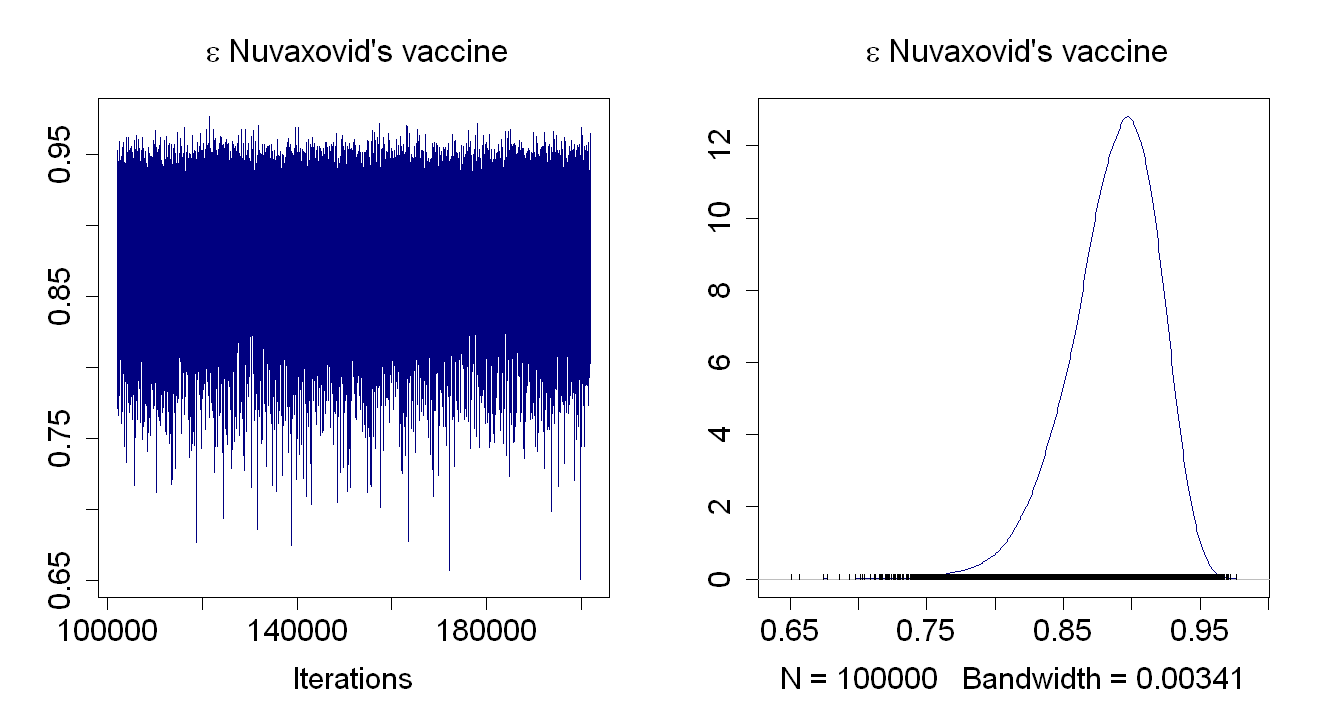

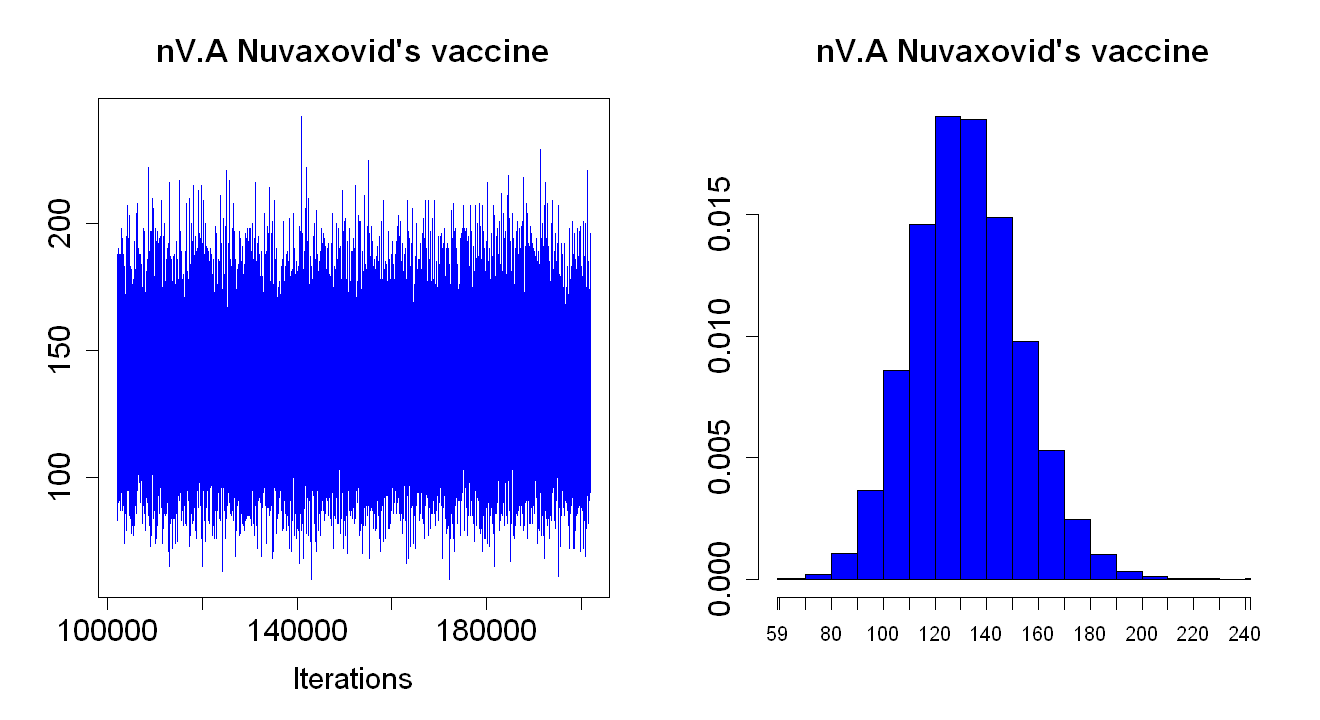

In [13]:
epsilon_nuvaxovid_mean <- Summary_nuvaxovid$statistics[1,1]
epsilon_nuvaxovid_std <- Summary_nuvaxovid$statistics[1,2]
mean.nV.A_nuvaxovid <- Summary_nuvaxovid$statistics[2,1]
std.nV.A_nuvaxovid <- Summary_nuvaxovid$statistics[2,2]
options(repr.plot.width=11, repr.plot.height =6)
plot(posterior_nuvaxovid[,1],trace=TRUE,col="navy",main =  ~ epsilon ~ "Nuvaxovid's vaccine",cex.lab=1.5, cex.axis=1.5, cex.main=1.6 )
plot(posterior_nuvaxovid[,2],trace=TRUE,col="blue",main =  "nV.A Nuvaxovid's vaccine",cex.lab=1.5, cex.axis=1.5, cex.main=1.6 )


In [54]:
samples_matrixE <- as.matrix(posterior_nuvaxovid) 
head(samples_matrixE,5)
density_E <- density(samples_matrixE[,1])
index_maxE <- which.max(density_E$y)

epsilon,nV.A
0.9024625,120
0.9168550,104
0.8996985,117
0.8409947,119
0.8642070,112


In [56]:
modeE <- density_E$x[index_maxE]

cat(paste("The MODE of Nuvaxovid's vaccine efficacy is", modeE ,"\n"))

Summary_nuvaxovid$quantiles
lower=Summary_nuvaxovid$quantiles[1,1]*100
upper=Summary_nuvaxovid$quantiles[1,5]*100
cat(paste('The 95% credible interval for Nuvaxovid vaccine efficacy is[',round(lower,1),'%,',round(upper,1),'%]'))


The MODE of Nuvaxovid's vaccine efficacy is 0.896568281271461 


,2.5%,25%,50%,75%,97.5%
epsilon,0.812041,0.8672942,0.8903623,0.9101275,0.9400265
nV.A,96.000000,119.0000000,132.0000000,146.0000000,175.0000000


The 95% credible interval for Nuvaxovid vaccine efficacy is[ 81.2 %, 94 %]

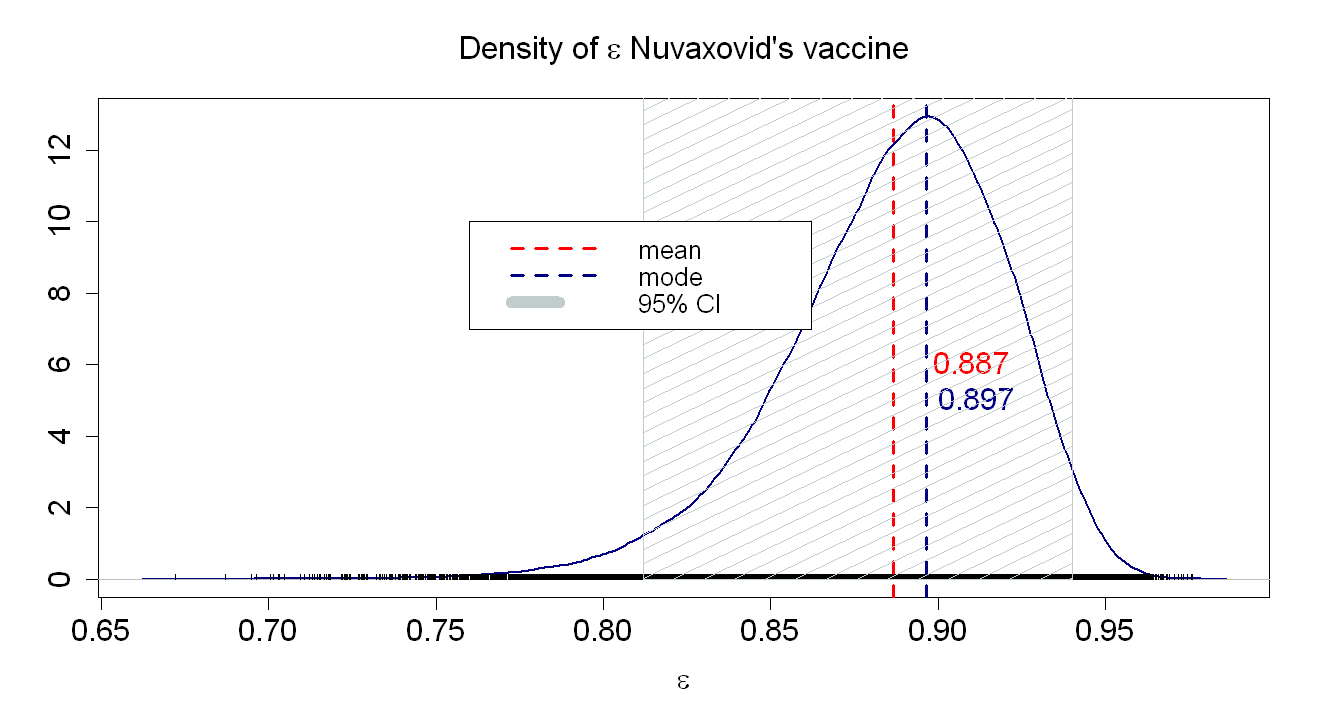

In [61]:
plot(posterior_nuvaxovid[,1],trace=FALSE,col="navy",xlab=expression(epsilon),main="Density of" ~ epsilon ~ "Nuvaxovid's vaccine",lwd=2,cex.lab=1.5, cex.axis=1.5, cex.main=1.6)
abline(v = epsilon_nuvaxovid_mean, col="red", lwd=3, lty=2)
abline(v = density_E$x[index_maxE], col="navy", lwd=3, lty=2)
text(density_E$x[index_maxE],         # position of text on x-axis
     5,                                               # position of text on y-axis
     round(density_E$x[index_maxE],digits = 3),         # text to be plotted
     pos = 4,col = "navy",cex=1.5) 
text(0.895,                                    # position of text on x-axis
     6,                                               # position of text on y-axis
     round(epsilon_nuvaxovid_mean,3),         # text to be plotted
     pos = 4,col = "red",cex=1.5) 
rect(lower*0.01, 0, upper*0.01, 16, density = 10, border = "azure3", col = "azure3")

legend(0.76, 10, legend=c("mean", "mode","95% CI"),
       col=c("red", "navy","azure3"), lty=c(2,2,2),lwd=c(3,3,10), cex=1.3) 



In [130]:
plot_95CI<- function(data,name) {
    model_jags <- model_load(data)
    update(model_jags, 1000) 
    post_sim <- coda.samples(model=model_jags,variable.names = c("epsilon","nV.A"),n.iter=100000)
    posterior<- post_sim
    Summary <- summary(posterior)
    epsilon_mean <- Summary$statistics[1,1]
    epsilon_std <- Summary$statistics[1,2]
    mean.nV.A <- Summary$statistics[2,1]
    std.nV.A<- Summary$statistics[2,2]
    samples_matrixE <- as.matrix(posterior) 
    head(samples_matrixE,5)
    density_E <- density(samples_matrixE[,1])
    index_maxE <- which.max(density_E$y)
    modeE <- density_E$x[index_maxE]

    lower=Summary$quantiles[1,1]*100
    upper=Summary$quantiles[1,5]*100
    plot(posterior[,1],trace=FALSE,col="navy",xlab=expression(epsilon),main=paste("Density of epsilon",name,"'s vaccine\n","95%CI=[]",round(lower,1),'%',round(upper,1),"%]"),lwd=2,cex.lab=1.5, cex.axis=1.5, cex.main=1.6)
    abline(v = epsilon_mean, col="red", lwd=3, lty=2)
    abline(v = density_E$x[index_maxE], col="navy", lwd=3, lty=2)
    text(density_E$x[index_maxE],         # position of text on x-axis
         5,                                               # position of text on y-axis
         round(density_E$x[index_maxE],digits = 3),         # text to be plotted
         pos = 4,col = "navy",cex=1.5) 
    text(density_E$x[index_maxE],                                    # position of text on x-axis
         6,                                               # position of text on y-axis
         round(epsilon_mean,3),         # text to be plotted
         pos = 4,col = "red",cex=1.5) 
    rect(lower*0.01, 0, upper*0.01, 16, density = 10, border = "azure3", col = "azure3")

    legend(lower*0.01-0.1, 10, legend=c("mean", "mode","95% CI"),
           col=c("red", "navy","azure3"), lty=c(2,2,2),lwd=c(3,3,10), cex=1.3) 

}

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 9

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 9

Initializing model



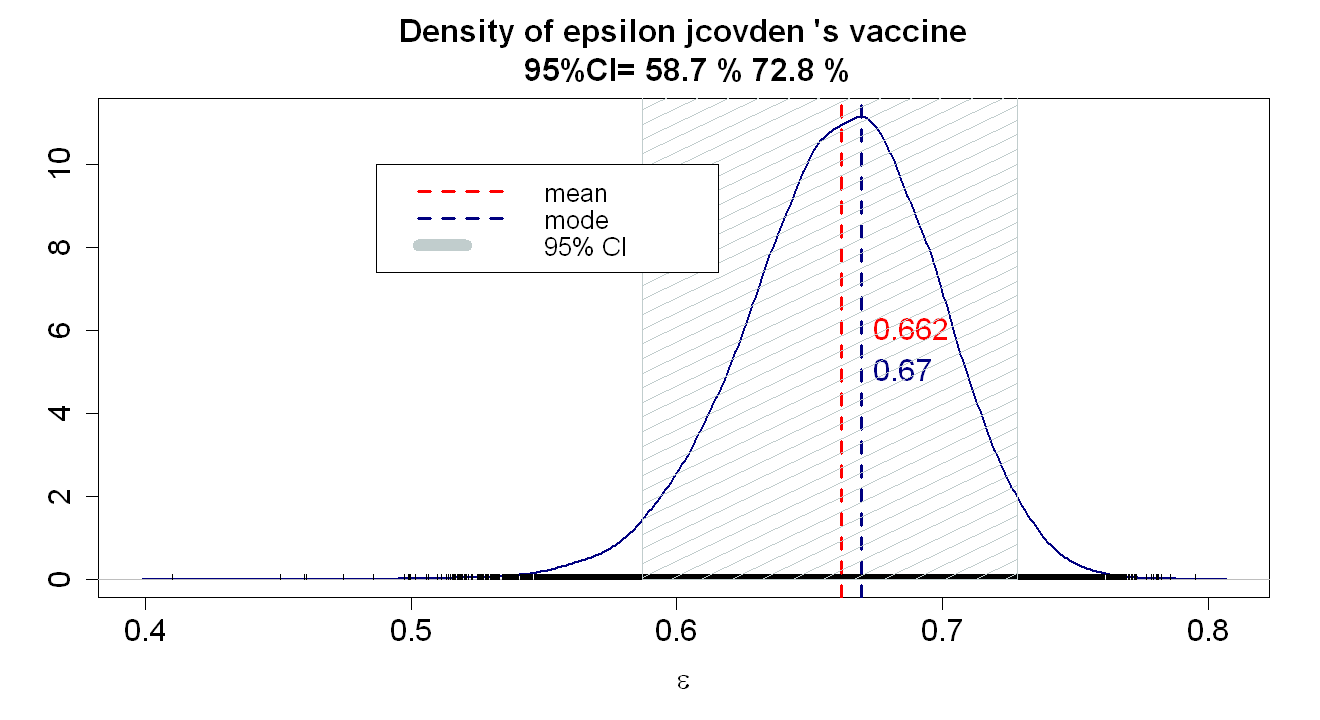

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 9

Initializing model



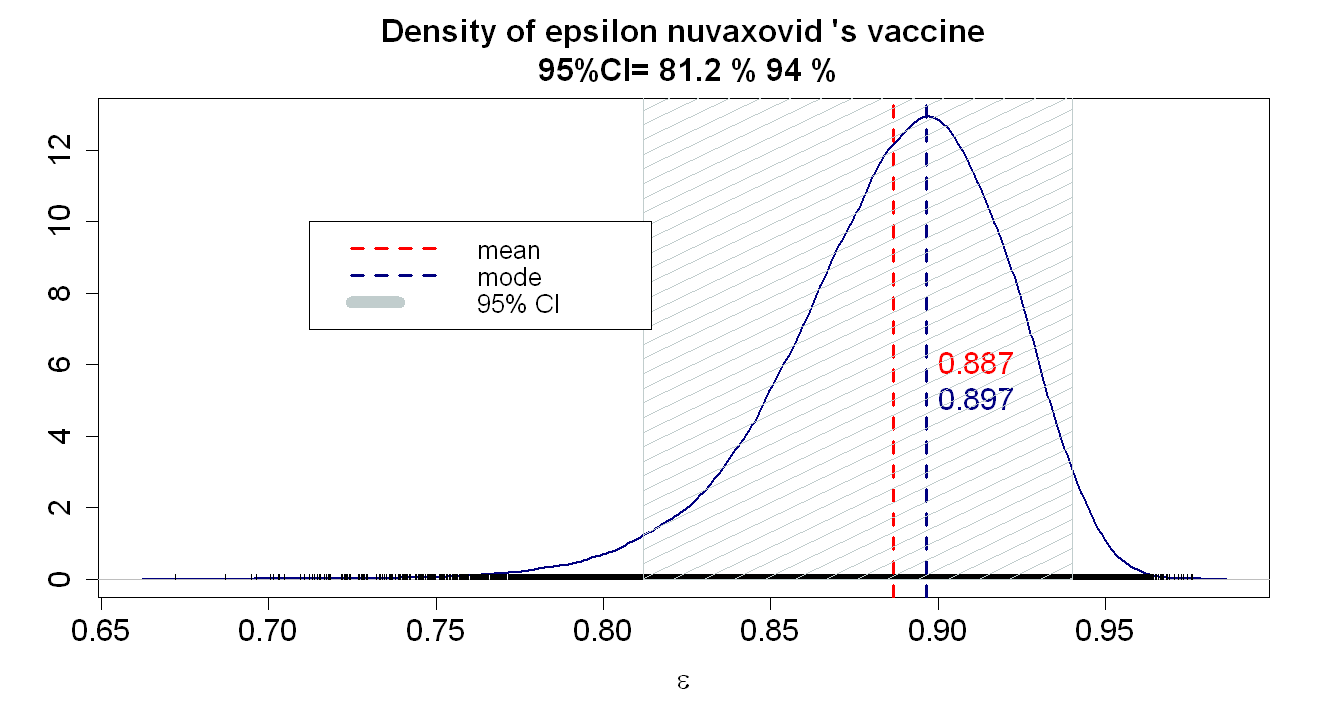

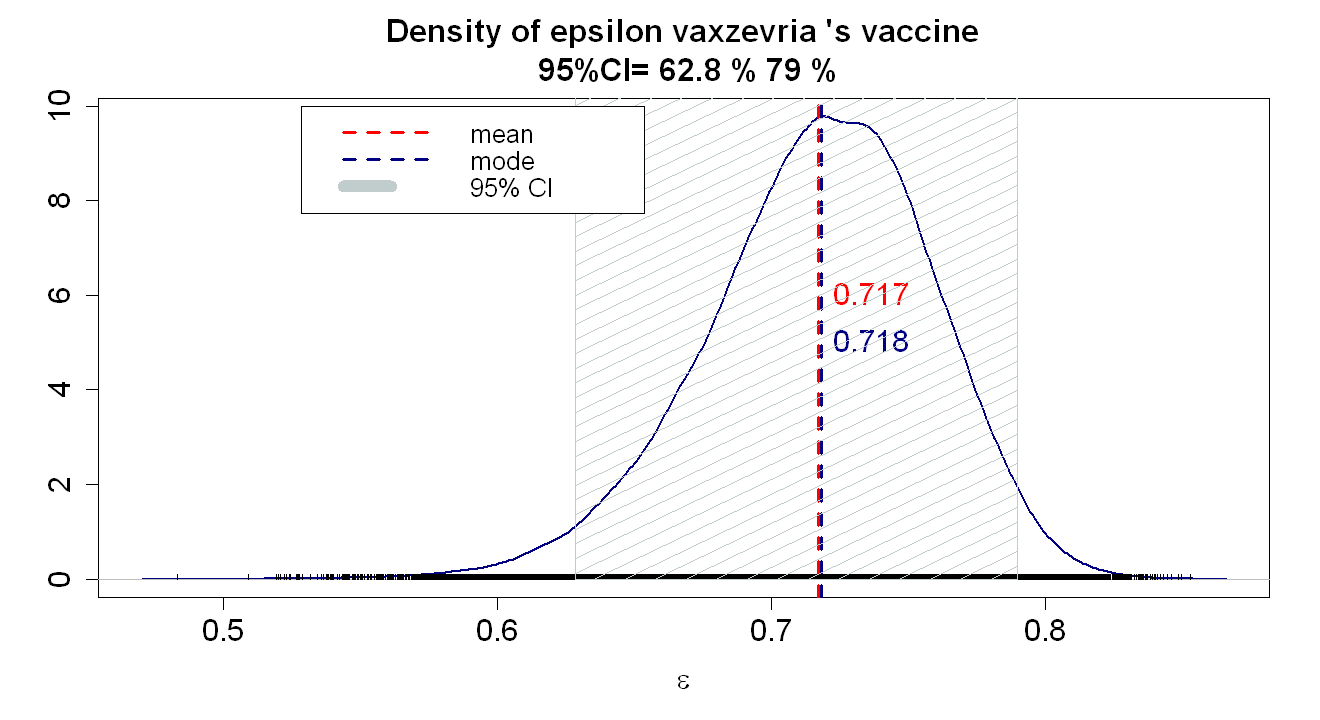

In [131]:
nuvaxovid <- list(nV.I=14,nP.I=63,nV=17312,nP=8140)
jcovden <-list(nV.I=116,nP.I=348,nV=19630,nP=19691)
pizer <- list(nV.I=8,nP.I=162,nV=28298,nP=18325)
spikevax <- list(nV.I=11,nP.I=185,nV=14134,nP=14073)
vaxzevria <- list(nV.I=73,nP.I=130,nV=17312,nP=8550)

plot_95CI(jcovden,"jcovden")
plot_95CI(nuvaxovid,"nuvaxovid")

plot_95CI(vaxzevria,"vaxzevria")

In [132]:
H_plot_95CI<- function(data,name) {
    model_jags <- model_load(data)
    update(model_jags, 1000) 
    post_sim <- coda.samples(model=model_jags,variable.names = c("epsilon","nV.A"),n.iter=100000)
    posterior<- post_sim
    Summary <- summary(posterior)
    epsilon_mean <- Summary$statistics[1,1]
    epsilon_std <- Summary$statistics[1,2]
    mean.nV.A <- Summary$statistics[2,1]
    std.nV.A<- Summary$statistics[2,2]
    samples_matrixE <- as.matrix(posterior) 
    head(samples_matrixE,5)
    density_E <- density(samples_matrixE[,1])
    index_maxE <- which.max(density_E$y)
    modeE <- density_E$x[index_maxE]

    lower=Summary$quantiles[1,1]*100
    upper=Summary$quantiles[1,5]*100
    plot(posterior[,1],trace=FALSE,col="navy",xlab=expression(epsilon),main=paste("Density of epsilon",name,"'s vaccine\n","95%CI=[]",round(lower,1),'%',round(upper,1),"%]"),lwd=2,cex.lab=1.5, cex.axis=1.5, cex.main=1.6)
    abline(v = epsilon_mean, col="red", lwd=3, lty=2)
    abline(v = density_E$x[index_maxE], col="navy", lwd=3, lty=2)
    text(density_E$x[index_maxE],         # position of text on x-axis
         8,                                               # position of text on y-axis
         round(density_E$x[index_maxE],digits = 3),         # text to be plotted
         pos = 4,col = "navy",cex=1.5) 
    text(density_E$x[index_maxE],                                    # position of text on x-axis
         6,                                               # position of text on y-axis
         round(epsilon_mean,3),         # text to be plotted
         pos = 4,col = "red",cex=1.5) 
    rect(lower*0.01, 0, upper*0.01, 35, density = 10, border = "azure3", col = "azure3")

    legend(lower*0.01-0.05, 10, legend=c("mean", "mode","95% CI"),
           col=c("red", "navy","azure3"), lty=c(2,2,2),lwd=c(3,3,10), cex=1.3) 

}

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 9

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 9

Initializing model



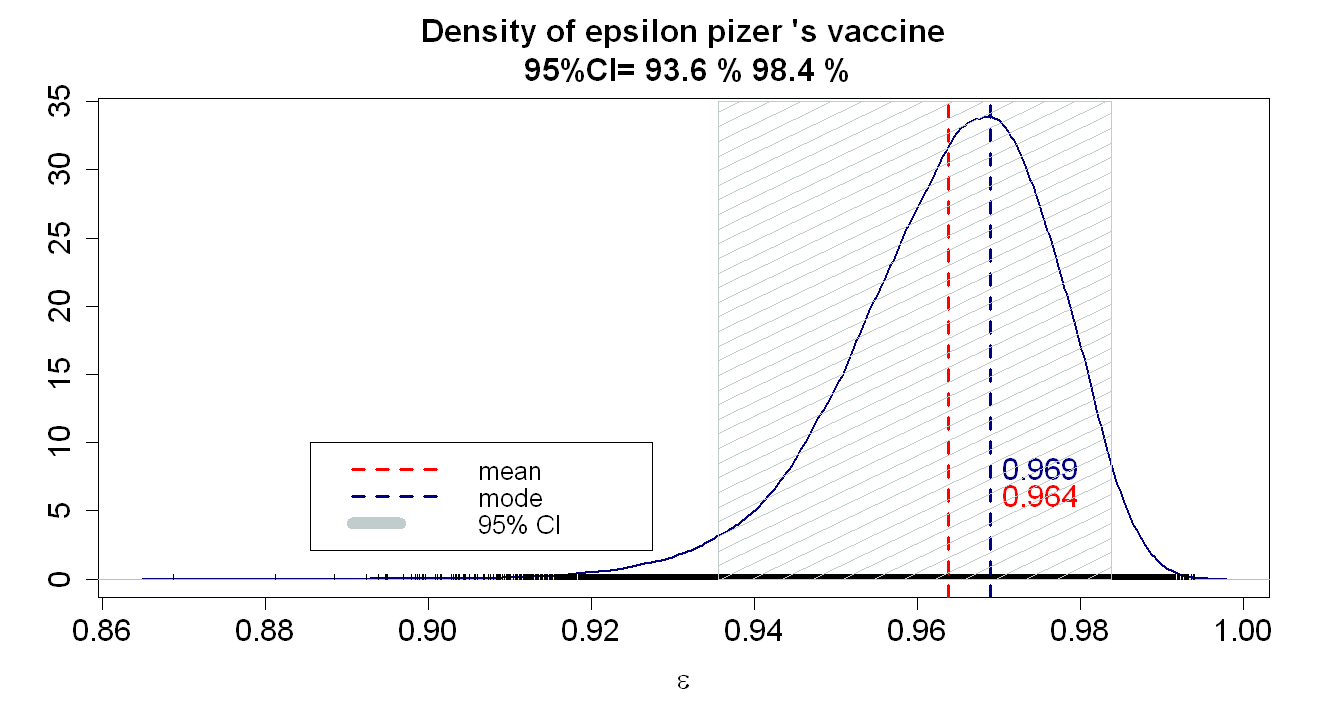

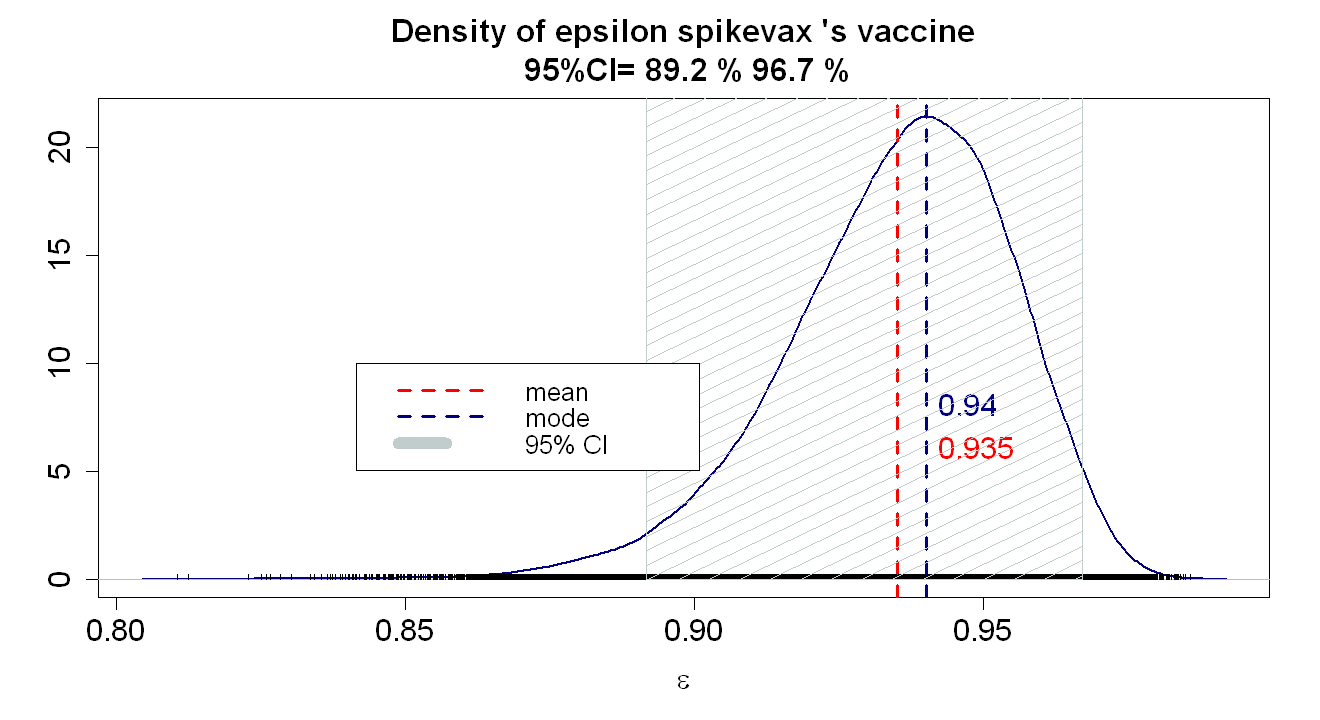

In [133]:
H_plot_95CI(pizer,"pizer")
H_plot_95CI(spikevax,"spikevax")